In [8]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd

from scipy.spatial.distance import euclidean
from numpy import array, zeros, argmin, inf, equal, ndim
from scipy.spatial.distance import cdist


In [9]:
d1 = glob.glob('Datasets/digit_data/isolated/36/1/*')
d2 = glob.glob('Datasets/digit_data/isolated/36/2/*')
d3 = glob.glob('Datasets/digit_data/isolated/36/3/*')

In [10]:
def load_mfcc(list_paths):
    X = []
    for i in list_paths:
        X.append(np.array(pd.read_csv(i, sep = " ", skiprows = [0], header = None))[:,1:])

    return np.array(X)

def combine(X):
    temp_X = []

    for i in X:
        for j in i:
            temp_X.append(j)

    return np.array(temp_X)

In [11]:
def plot_elbow(X, K=10):
    
    distortions = []
    for k in range(1,K):
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    plt.plot(range(1,K), distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
def get_labels(X, K):
    clf = KMeans(n_clusters = K)
    clf.fit(X)

    # Gives the final cetnroids of each cluster
    centroids = clf.cluster_centers_

    # Label of each data-point
    return clf.labels_

In [12]:
# Load and structure data
X1 = load_mfcc(d1)
X2 = load_mfcc(d2)
X3 = load_mfcc(d3)

# Train Test data partition
X1_train,X1_test = train_test_split(X1, test_size=0.3, random_state=42)
X2_train,X2_test = train_test_split(X2, test_size=0.3, random_state=42)
X3_train,X3_test = train_test_split(X3, test_size=0.3, random_state=42)

In [13]:
#plot_elbow(np.vstack((combine(X1_train), combine(X2_train), combine(X3_train))), 15)

In [14]:
def build_train_data(label_data, before_combine_data):
    start = 0
    end = start
    temp_labels = []
    for i in before_combine_data:
        bound = i.shape[0]
        temp_labels.append(label_data[start:end+bound])
        start = end+bound
        end = start

    return np.array(temp_labels)

In [15]:
def combine(X):
    temp_X = []

    for i in X:
        for j in i:
            temp_X.append(j)

    return np.array(temp_X)

In [16]:
def get_labels(X, K):
    clf = KMeans(n_clusters = K)
    clf.fit(X)

    # Gives the final cetnroids of each cluster
    centroids = clf.cluster_centers_

    # Label of each data-point
    return clf.labels_

In [17]:
def generate_out(X1, X2, X3, K):
    cX1 = combine(X1)
    cX2 = combine(X2)
    cX3 = combine(X3)    

    X = np.vstack((cX1, cX2, cX3))

    c_d = get_labels(X, K)

    c1 = c_d[0:cX1.shape[0]]
    c2 = c_d[cX1.shape[0]:cX1.shape[0]+cX2.shape[0]]
    c3 = c_d[cX1.shape[0]+cX2.shape[0]:]

    d1_labels = build_train_data(c1, X1)
    d2_labels = build_train_data(c2, X2)
    d3_labels = build_train_data(c3, X3)

    return (d1_labels, d2_labels, d3_labels)

In [18]:
def write_outfile(np_array, filename="np_array.out"):
    with open(filename, 'w') as f:
        for row in np_array:
            temp = ''
            for item in row:
                temp = temp+str(item)+' '
            f.write(temp+'\n')
    print("Dumped to "+filename)

In [19]:
# Discretize the training data using K means
t1,t2,t3 = generate_out(X1_train, X2_train, X3_train, 4)
write_outfile(t1,'d1_labels.out')
write_outfile(t2,'d2_labels.out')
write_outfile(t3,'d3_labels.out')

Dumped to d1_labels.out
Dumped to d2_labels.out
Dumped to d3_labels.out


In [20]:
# Discretize the testing data using K means
t4,t5,t6 = generate_out(X1_test, X2_test, X3_test, 4)
write_outfile(t4,'d1_labels_test.out')
write_outfile(t5,'d2_labels_test.out')
write_outfile(t6,'d3_labels_test.out')

Dumped to d1_labels_test.out
Dumped to d2_labels_test.out
Dumped to d3_labels_test.out


In [21]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [22]:
def fastdtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
    Instead of iterating through each element and calculating each distance,
    this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

    :param array x: N1*M array
    :param array y: N2*M array
    :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
    If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    if ndim(x)==1:
        x = x.reshape(-1,1)
    if ndim(y)==1:
        y = y.reshape(-1,1)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]
    D0[1:,1:] = cdist(x,y,dist)
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return (D1[-1, -1] / sum(D1.shape), C, D1, path)

In [27]:
#from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import euclidean
from nltk.metrics.distance import edit_distance
from sklearn.metrics.pairwise import manhattan_distances

dist_fun = euclidean

In [28]:
x = t1[0]
y = t4[0]

In [29]:
dist, cost, acc, path = fastdtw(x, y, dist_fun)

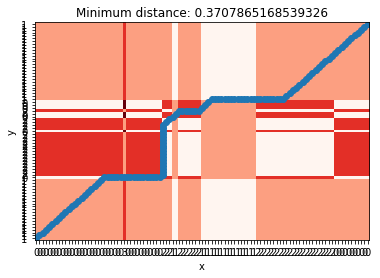

In [30]:
# vizualize

from matplotlib import pyplot as plt
plt.imshow(cost.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], '-o') # relation
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.title('Minimum distance: {}'.format(dist))
plt.show()

In [35]:
first_limit = t1.shape[0]-1
second_limit = first_limit + t2.shape[0]
third_limit = second_limit + t3.shape[0]

In [36]:
test_data = np.hstack((t4, t5, t6))

In [37]:
from datetime import datetime
startTime = datetime.now()

predict = np.array([-1] * test_data.shape[0])
min_dist = np.array([-1] * test_data.shape[0])

for j in range(test_data.shape[0]):
    y = test_data[j]
    
    distance = []
    
    for i in range(t1.shape[0]):
        x = t1[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)

    for i in range(t2.shape[0]):
        x = t2[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)

    for i in range(t3.shape[0]):
        x = t3[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)
        
    index = argmin(distance)
    min_dist[j] = min(distance)

    if index <= first_limit:
        predict[j] = 1
    elif index > first_limit and index <= second_limit:
        predict[j] = 2
    else:
        predict[j] = 3
        
print(datetime.now() - startTime)

0:11:38.181014


In [38]:
actual_test_labels = np.hstack((np.array([1]*X1_test.shape[0]), np.array([2]*X2_test.shape[0]), np.array([3]*X3_test.shape[0])))

In [39]:
score = 0
descore = 0
misclassified = []
for i in range(test_data.shape[0]):
    if actual_test_labels[i] == predict[i]:
        score += 1
    else:
        descore += 1
        misclassified.append(i)
        
rec_rate = score / test_data.shape[0]
print('Recognition rate {}%'.format(100. * rec_rate))

Recognition rate 48.148148148148145%


In [42]:
np.array(misclassified).T

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 19,
       20, 22, 27, 30, 33, 34, 35, 41, 44, 45, 52])

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
1
3
3
3
3
3
2
2
2
2
